# MovieLens 1M Collaborative Genre Tagging
  - [paperswithcode link](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-1m)
  - [ML 1m state of the art paper](http://proceedings.mlr.press/v80/muller18a/muller18a.pdf) (RMSE=0.824): details their evaluation method
  
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/James-Leslie/deep-collaborative-filtering/blob/master/CGT-short.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Load rating data
  - remove 10% as holdout test set

In [2]:
path = 'https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/data/ml-1m/'  # access from anywhere
df = pd.read_csv(path+'ratings.csv', usecols=['userId','movieId','rating'])

In [3]:
df.head()

,userId,movieId,rating
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5


In [4]:
df.shape

(1000209, 3)

In [5]:
n_users = df.userId.nunique()
n_movies = df.movieId.nunique()

print('Number of users:', n_users)
print('Number of items:', n_movies)
print("Min item rating:", df.rating.min())
print("Max item rating:", df.rating.max())
print("Mean item rating:", df.rating.mean())

Number of users: 6040
Number of items: 3706
Min item rating: 1
Max item rating: 5
Mean item rating: 3.581564453029317


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
df, df_holdout = train_test_split(df, test_size=.1, random_state=42)

## Load movie metadata
  - remove 10% as holdout test set

In [8]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,One Flew Over the Cuckoo's Nest (1975),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,James and the Giant Peach (1996),0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,My Fair Lady (1964),0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,3,Erin Brockovich (2000),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,4,"Bug's Life, A (1998)",0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
movies, movies_holdout = train_test_split(movies, test_size=.1, random_state=42)

---
# 1. Rating model
## 1.1. Model architecture
![rating_model](https://github.com/James-Leslie/deep-collaborative-filtering/blob/master/figures/png_images/rating-model.png?raw=true)

### Include user and item bias
![baselines](https://github.com/James-Leslie/deep-collaborative-filtering/blob/master/figures/png_images/baseline.png?raw=true)

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Add, Dense, Concatenate, Dropout, LeakyReLU
from tensorflow.keras.models import Model

In [11]:
# item latent factors
item_in = Input(shape=[1])  # name='item'
item_em = Embedding(n_movies, 50)(item_in)
item_vec = Flatten()(item_em)
# user latent factors
user_in = Input(shape=[1])
user_em = Embedding(n_users, 50)(user_in)
user_vec = Flatten()(user_em)
# concatenate user and item vectors
conc = Concatenate()([item_vec, user_vec])
# hidden layer with leaky ReLU and dropout
x = Dense(50)(conc)
x = LeakyReLU(alpha=.15)(x)
x = Dropout(.3)(x)
# item bias
item_bias = Embedding(n_movies, 1)(item_in)
item_bias = Flatten()(item_bias)
# user bias
user_bias = Embedding(n_users, 1)(user_in)
user_bias = Flatten()(user_bias)
# output
x = Dense(1, activation='sigmoid')(x)
x = tf.math.scalar_mul(4, x)
x = tf.math.add(tf.constant([1.0]), x)
rating = Add()([x, item_bias, user_bias])
# create model and compile it
model = Model([user_in, item_in], rating)
model.compile(optimizer='adam', loss='mean_squared_error')

# show summary of model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        185300      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        302000      input_2[0][0]                    
______________________________________________________________________________________________

---
## 1.2. Train model

Train on 720150 samples, validate on 180038 samples
Epoch 1/7
720150/720150 [==============================] - 6s 8us/sample - loss: 0.8930 - val_loss: 0.8235
Epoch 2/7
720150/720150 [==============================] - 5s 6us/sample - loss: 0.8125 - val_loss: 0.8122
Epoch 3/7
720150/720150 [==============================] - 5s 6us/sample - loss: 0.7988 - val_loss: 0.8051
Epoch 4/7
720150/720150 [==============================] - 5s 6us/sample - loss: 0.7890 - val_loss: 0.7986
Epoch 5/7
720150/720150 [==============================] - 5s 7us/sample - loss: 0.7770 - val_loss: 0.7875
Epoch 6/7
720150/720150 [==============================] - 5s 7us/sample - loss: 0.7642 - val_loss: 0.7803
Epoch 7/7
720150/720150 [==============================] - 5s 7us/sample - loss: 0.7534 - val_loss: 0.7750


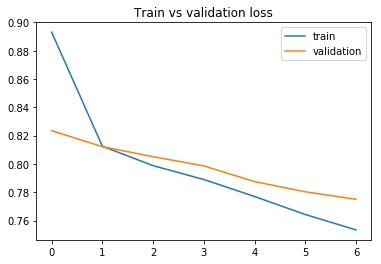

In [12]:
# train rating model on all data
result = model.fit(
    x=[df.userId.values, df.movieId.values],
    y=df.rating.values,
    batch_size=1028,
    epochs=7,
    verbose=1,
    validation_split=.2
)

# plot training curve of best model
plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='validation')
plt.title('Train vs validation loss')
plt.legend()
plt.show()

## 1.3. Holdout performance

In [13]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [14]:
y_true = df_holdout.rating.values
y_pred = model.predict([df_holdout.userId.values, df_holdout.movieId.values], batch_size=2056)

In [15]:
df_holdout['y_pred'] = y_pred
df_holdout.head()

,userId,movieId,rating,y_pred
895536,5411,352,2,3.768351
899739,5439,629,5,4.977857
55687,367,387,4,3.209677
63727,424,27,4,3.417053
822011,4941,1674,1,3.155049


In [16]:
print('RMSE:', '{0:.3f}'.format(np.sqrt(mse(y_true, y_pred))))
print('MAE:', '{0:.3f}'.format(mae(y_true, y_pred)))

RMSE: 0.883
MAE: 0.696


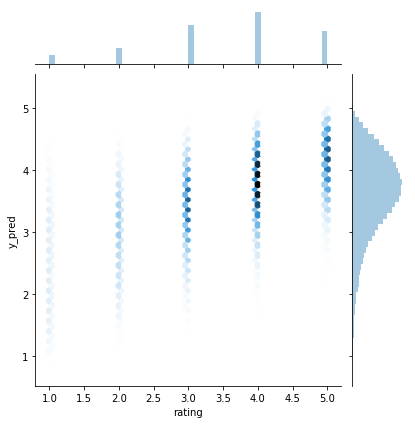

In [17]:
sns.jointplot(x='rating', y='y_pred', data=df_holdout, kind='hex')

# 2. Genre model
## 2.1. Model architecture
Re-use the item embedding layer, but freeze the weights.
![transfer-weights](https://github.com/James-Leslie/deep-collaborative-filtering/blob/master/figures/png_images/transfer-learning.png?raw=true)

In [18]:
# hidden layer with leaky ReLU and dropout
x = Dense(50, activation='relu')(item_vec)
x = LeakyReLU(alpha=.1)(x)
x = Dropout(.2)(x)
# add sigmoid activation function
genre = Dense(1, activation='sigmoid')(x)
# create model and compile it
model2 = Model(item_in, genre)
# freeze the embedding layer
model2.layers[1].trainable = False
model2.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy', 'AUC'])

# show model summary
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 1, 50)             185300    
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51  

## 2.2. Train model

In [19]:
# train genre model
results = model2.fit(
    movies.movieId.values, movies.Drama.values,
    batch_size=64, 
    epochs=5,
    validation_split=.2,
    class_weight={0:.4, 1:.6})

Train on 2668 samples, validate on 667 samples
Epoch 1/5
2668/2668 [==============================] - 1s 312us/sample - loss: 0.3258 - accuracy: 0.5930 - AUC: 0.6384 - val_loss: 0.3144 - val_accuracy: 0.5817 - val_AUC: 0.6312
Epoch 2/5
2668/2668 [==============================] - 0s 33us/sample - loss: 0.3152 - accuracy: 0.6184 - AUC: 0.6634 - val_loss: 0.3120 - val_accuracy: 0.5862 - val_AUC: 0.6337
Epoch 3/5
2668/2668 [==============================] - 0s 36us/sample - loss: 0.3147 - accuracy: 0.6098 - AUC: 0.6584 - val_loss: 0.3116 - val_accuracy: 0.5862 - val_AUC: 0.6356
Epoch 4/5
2668/2668 [==============================] - 0s 34us/sample - loss: 0.3124 - accuracy: 0.6139 - AUC: 0.6661 - val_loss: 0.3111 - val_accuracy: 0.5847 - val_AUC: 0.6368
Epoch 5/5
2668/2668 [==============================] - 0s 34us/sample - loss: 0.3118 - accuracy: 0.6154 - AUC: 0.6693 - val_loss: 0.3118 - val_accuracy: 0.5847 - val_AUC: 0.6375


## 2.3. Holdout performance

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

### Evaluate on test set

In [21]:
X_test = movies_holdout.movieId.values
y_test = movies_holdout.Drama.values
y_score = pd.DataFrame(model2.predict(X_test))
y_pred = y_score.round().astype('int')

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.47      0.58       227
           1       0.48      0.76      0.59       144

    accuracy                           0.58       371
   macro avg       0.62      0.62      0.58       371
weighted avg       0.65      0.58      0.58       371



In [23]:
pd.DataFrame(confusion_matrix(y_test, y_pred), index=['P0', 'P1'], columns=['T0', 'T1'])

,T0,T1
P0,107,120
P1,34,110
